In [114]:
# ALGORITHM
#project into boundary box - check existing functions (https://stackoverflow.com/questions/23901943/voronoi-compute-exact-boundaries-of-every-region/52727406#52727406)
#for each grain 
#don't need: get all edges (https://stackoverflow.com/questions/23658776/voronoi-diagram-edges-how-to-get-edges-in-the-form-point1-point2-from-a-scip)
#merge into a single polygon (https://stackoverflow.com/questions/27548363/from-voronoi-tessellation-to-shapely-polygons?noredirect=1&lq=1)

#for each grain
#for each neighbor
#find shared boundary (https://gis.stackexchange.com/questions/197652/find-common-borders-of-features-and-get-their-attributes-using-fiona-and-shapely)
#calculate length

#find points on boundary
#use NN for average misorientation

In [214]:
#load libraries
import numpy as np
from numpy import random
import math
from math import sqrt
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
%matplotlib inline
from statistics import mean
from scipy.stats import norm, lognorm
import seaborn as sns
sns.set()
sns.set_style('white')
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance, Voronoi, voronoi_plot_2d, ConvexHull, Delaunay
from collections import defaultdict
import itertools
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import sys
from itertools import combinations, islice 
import time
from scipy import stats
from sklearn.svm import SVC 
from shapely import geometry, ops
import matplotlib.animation as animation
from celluloid import Camera
from scipy.stats import entropy
import sobol_seq
from shapely import geometry
from shapely.geometry import Polygon, LineString
from shapely.ops import unary_union

In [113]:
#load data
raw_data = np.loadtxt('Data Files/EBSD Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(0,1,2,3,4,8,9))
xy_max=12
raw_data_slice=raw_data[np.where((raw_data[:,3]<=xy_max) & (raw_data[:,4]<=xy_max))]

In [203]:
def js_divergence_scipy(hist1,hist2):
    return (distance.jensenshannon(hist1, hist2, base=2))**2

def nearest_neighbors(values, all_values, nbr_neighbors=1):
    nn = NearestNeighbors(nbr_neighbors, metric='euclidean', algorithm='kd_tree').fit(all_values)
    dists, idxs = nn.kneighbors(values)
    return idxs

def hexagonal_sym_ops():
    #everything to calculate disorientations
    a=sqrt(0.75)

    #12 hexagonal close-packed crystal symmetry operators
    op25=np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]])
    op26=np.array([[-0.5, a, 0],[-a, -0.5, 0],[0, 0, 1]])
    op27=np.array([[-0.5, -a, 0],[a, -0.5, 0],[0, 0, 1]])
    op28=np.array([[0.5, a, 0],[-a, 0.5, 0],[0, 0, 1]])
    op2=np.array([[-1, 0, 0],[0, -1, 0],[0, 0, 1]])
    op30=np.array([[0.5, -a, 0],[a, 0.5, 0],[0, 0, 1]])
    op31=np.array([[-0.5, -a, 0],[-a, 0.5, 0],[0, 0, -1]])
    op32=np.array([[1, 0, 0],[0, -1, 0],[0, 0, -1]])
    op33=np.array([[-0.5, a, 0],[a, 0.5, 0],[0, 0, -1]])
    op34=np.array([[0.5, a, 0],[a, -0.5, 0],[0, 0, -1]])
    op35=np.array([[-1, 0, 0],[0, 1, 0],[0, 0, -1]])
    op36=np.array([[0.5, -a, 0],[-a, -0.5, 0],[0, 0, -1]])

    op25,op26,op27,op28,op2,op30,op31,op32,op33,op34,op35,op36

    #list of hexagonal sym ops
    return [op25,op26,op27,op28,op2,op30,op31,op32,op33,op34,op35,op36]

#input is an array in radians as follows euler=[angle_one,angle_two,angle_three]
def misorientation(euler_one, euler_two,sym_op):
    #orientation matrices
    g_one=np.array([[((math.cos(euler_one[0]))*(math.cos(euler_one[2]))-(math.sin(euler_one[0]))*(math.sin(euler_one[2]))*(math.cos(euler_one[1]))),((math.sin(euler_one[0]))*(math.cos(euler_one[2]))+(math.cos(euler_one[0]))*(math.sin(euler_one[2]))*(math.cos(euler_one[1]))),((math.sin(euler_one[2]))*(math.sin(euler_one[1])))],
                [(-(math.cos(euler_one[0]))*(math.sin(euler_one[2]))-(math.sin(euler_one[0]))*(math.cos(euler_one[2]))*(math.cos(euler_one[1]))),(-(math.sin(euler_one[0]))*(math.sin(euler_one[2]))+(math.cos(euler_one[0]))*(math.cos(euler_one[2]))*(math.cos(euler_one[1]))),((math.cos(euler_one[2]))*(math.sin(euler_one[1])))],
                [((math.sin(euler_one[0]))*(math.sin(euler_one[1]))),(-(math.cos(euler_one[0]))*(math.sin(euler_one[1]))),(math.cos(euler_one[1]))]        
                ])
   
    #euler_two
    g_two=np.array([[((math.cos(euler_two[0]))*(math.cos(euler_two[2]))-(math.sin(euler_two[0]))*(math.sin(euler_two[2]))*(math.cos(euler_two[1]))),((math.sin(euler_two[0]))*(math.cos(euler_two[2]))+(math.cos(euler_two[0]))*(math.sin(euler_two[2]))*(math.cos(euler_two[1]))),((math.sin(euler_two[2]))*(math.sin(euler_two[1])))],
                [(-(math.cos(euler_two[0]))*(math.sin(euler_two[2]))-(math.sin(euler_two[0]))*(math.cos(euler_two[2]))*(math.cos(euler_two[1]))),(-(math.sin(euler_two[0]))*(math.sin(euler_two[2]))+(math.cos(euler_two[0]))*(math.cos(euler_two[2]))*(math.cos(euler_two[1]))),((math.cos(euler_two[2]))*(math.sin(euler_two[1])))],
                [((math.sin(euler_two[0]))*(math.sin(euler_two[1]))),(-(math.cos(euler_two[0]))*(math.sin(euler_two[1]))),(math.cos(euler_two[1]))]        
                ])
    
#     #misorientation matrix
    delta_g=np.matmul(g_one,np.linalg.inv(g_two))
    
    #disorientation matrix
    delta_gd=np.matmul(sym_op,delta_g)
    
    #misorientation angle
    try:
        theta=np.arccos((np.trace(delta_gd)-1)/2)
    #error handling for rounding errors outside of domain
    except:
        if (((np.trace(delta_gd)-1)/2)>1):
            theta=0
        else:
            theta=180

    return math.degrees(theta)


#find the minimum misorientation using sym ops
def disorientation(euler_one, euler_two):
    global hex_sym_ops
    
    misorientation_list=[]
    for sym_op in hex_sym_ops:
        misorientation_list.append(misorientation(euler_one, euler_two,sym_op))
    
    #disorientation is the minimum of the 24 misorientations - for cubic symmetry 
    return min(misorientation_list)

hex_sym_ops=hexagonal_sym_ops()

In [196]:
def point_adj_dict(data):
    coords=data[:,[3,4]]
    tri=Delaunay(coords)
    neigh=defaultdict(set)
    for p in tri.simplices:
        for i,j in itertools.combinations(p,2):
            neigh[i].add(j)
            neigh[j].add(i)
    return neigh

def grain_adj_dict(data, point_adj):
    grain_adj=defaultdict(set)
    for key in point_adj:
        grain_ID_1=data[key][5]
        for value in point_adj[key]:
            grain_ID_2=data[value][5]
            if grain_ID_1 != grain_ID_2:
                #dict grain
                grain_adj[int(grain_ID_1)].add(grain_ID_2)
                grain_adj[int(grain_ID_2)].add(grain_ID_1)
    return grain_adj

In [116]:
def voronoi_polygons(voronoi, diameter):
    """Generate shapely.geometry.Polygon objects corresponding to the
    regions of a scipy.spatial.Voronoi object, in the order of the
    input points. The polygons for the infinite regions are large
    enough that all points within a distance 'diameter' of a Voronoi
    vertex are contained in one of the infinite polygons.

    """
    centroid = voronoi.points.mean(axis=0)

    # Mapping from (input point index, Voronoi point index) to list of
    # unit vectors in the directions of the infinite ridges starting
    # at the Voronoi point and neighbouring the input point.
    ridge_direction = defaultdict(list)
    for (p, q), rv in zip(voronoi.ridge_points, voronoi.ridge_vertices):
        u, v = sorted(rv)
        if u == -1:
            # Infinite ridge starting at ridge point with index v,
            # equidistant from input points with indexes p and q.
            t = voronoi.points[q] - voronoi.points[p] # tangent
            n = np.array([-t[1], t[0]]) / np.linalg.norm(t) # normal
            midpoint = voronoi.points[[p, q]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - centroid, n)) * n
            ridge_direction[p, v].append(direction)
            ridge_direction[q, v].append(direction)
    
#     for i, r in islice(enumerate(voronoi.point_region),0,2):
    for i, r in enumerate(voronoi.point_region):
        region = voronoi.regions[r]
        if -1 not in region:
            # Finite region.
            yield Polygon(voronoi.vertices[region])
            continue
        # Infinite region.
        inf = region.index(-1)              # Index of vertex at infinity.
        j = region[(inf - 1) % len(region)] # Index of previous vertex.
        k = region[(inf + 1) % len(region)] # Index of next vertex.
        if j == k:
            # Region has one Voronoi vertex with two ridges.
            dir_j, dir_k = ridge_direction[i, j]
        else:
            # Region has two Voronoi vertices, each with one ridge.
            dir_j, = ridge_direction[i, j]
            dir_k, = ridge_direction[i, k]

        # Length of ridges needed for the extra edge to lie at least
        # 'diameter' away from all Voronoi vertices.
        length = 2 * diameter / np.linalg.norm(dir_j + dir_k)

        # Polygon consists of finite part plus an extra edge.
        finite_part = voronoi.vertices[region[inf + 1:] + region[:inf]]
        extra_edge = [voronoi.vertices[j] + dir_j * length,
                      voronoi.vertices[k] + dir_k * length]
        yield Polygon(np.concatenate((finite_part, extra_edge)))

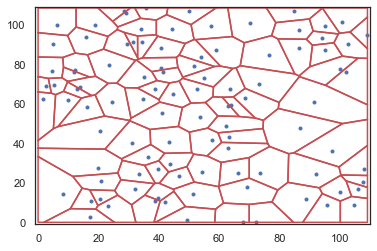

In [173]:
# points=array[np.random.choice(array.shape[0], len(array), replace=False),3:5]
# boundary = np.array([[0, 0], [0, np.amax(array[:,4])], [np.amax(array[:,3]), np.amax(array[:,4])], [np.amax(array[:,3]), 0]])

# x, y = boundary.T
# plt.xlim(round(x.min() - 1), round(x.max() + 1))
# plt.ylim(round(y.min() - 1), round(y.max() + 1))
# plt.plot(*points.T, 'b.')

# diameter = np.linalg.norm(boundary.ptp(axis=0))
# boundary_polygon = Polygon(boundary)
# for p in voronoi_polygons(Voronoi(points), diameter):
#     x, y = zip(*p.intersection(boundary_polygon).exterior.coords)
#     plt.plot(x, y, 'r-')

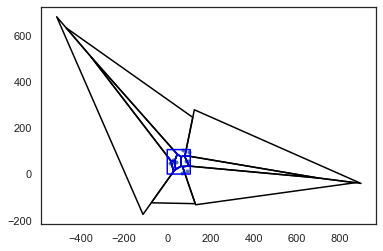

In [176]:
# # points = np.array([[0.1, -0.4], [0, 1.5], [0, 2.25], [1, 0], [1, 1], [1, 2], [2, 0], [2.5, 1], [2, 2], [2.3, 2.3], [-0.5, -1.3], [-1.5, 3]])
# points=array[np.random.choice(array.shape[0], 10, replace=False),3:5]
# # boundary = np.array([[-5, -2], [3.4, -2], [4.7, 4], [2.7, 5.7], [-1, 4]])
# boundary = np.array([[0, 0], [0, np.amax(array[:,4])], [np.amax(array[:,3]), np.amax(array[:,4])], [np.amax(array[:,3]), 0]])

# x, y = boundary.T
# # plt.xlim(round(x.min() - 1), round(x.max() + 1))
# # plt.ylim(round(y.min() - 1), round(y.max() + 1))
# plt.plot(*points.T, 'b.')

# diameter = np.linalg.norm(boundary.ptp(axis=0))
# boundary_polygon = Polygon(boundary)
# for p in voronoi_polygons(Voronoi(points), diameter):
#     plt.plot(*p.exterior.xy, color='black')
#     p2=p.intersection(boundary_polygon)
#     plt.plot(*p2.exterior.xy, color='blue')
    
# plt.show()

In [169]:
#PLAN
#create list of constrained polygons 
#create dict of grain ID and corresponding polygons
#list of tuples - ID 

In [227]:
# array=np.copy(raw_data)
# array=array[np.random.choice(array.shape[0], 100, replace=False),:]
# points_and_IDs=array[:,3:6]
# points=points_and_IDs[:,0:2]

# boundary = np.array([[0, 0], [0, np.amax(array[:,4])], [np.amax(array[:,3]), np.amax(array[:,4])], [np.amax(array[:,3]), 0]])
# diameter = np.linalg.norm(boundary.ptp(axis=0))
# boundary_polygon = Polygon(boundary)

# bounded_poly_list=[]
# for p in voronoi_polygons(Voronoi(points), diameter):
#     bounded_p=p.intersection(boundary_polygon)
#     bounded_poly_list.append(bounded_p)

In [228]:
# # for p in [bounded_poly_list[i] for i in [15,40,60,81,89,98]]:
# #     plt.plot(*p.exterior.xy, color='black')

# for p in bounded_poly_list:
#     plt.plot(*p.exterior.xy, color='black')

In [229]:
# for grain_ID in np.unique(IDs):
#     print(grain_ID)
#     print(np.where(IDs==grain_ID))

In [230]:
# invalid=[]
# merged_poly_list=[]
# IDs=points_and_IDs[:,2]
# for grain_ID in np.unique(IDs):
#     indexes=np.where(IDs==grain_ID)
#     grain_fragments=[bounded_poly_list[i] for i in indexes[0]]
#     grain_poly=unary_union(grain_fragments)
#     if grain_poly.geom_type=='MultiPolygon': #invalid split grain
#         invalid.append(grain_ID)
#         merged_poly_list.append(np.nan)
#     else:
# #         plt.plot(*grain_poly.exterior.xy, color='black')
#         merged_poly_list.append(grain_poly)

In [298]:
# #point and grain adj dicts
# point_adj=point_adj_dict(array)
# grain_adj=grain_adj_dict(array,point_adj)

# #store boundary lens and misorients
# boundary_lens=[]
# boundary_misorients=[]

# # for grain_ID_1 in grain_adj:
# for grain_ID_1 in [738]:
#     #invalid geometry
#     if grain_ID_1 in invalid:
#         break
#     #get first grain polygon
#     index=np.where(np.unique(IDs)==grain_ID_1)
#     poly_1=merged_poly_list[int(index[0])]
#     for grain_ID_2 in grain_adj[grain_ID_1]:
#         #invalid geometry
#         if grain_ID_2 in invalid:
#             break
#         #get second grain polygon
#         index=np.where(np.unique(IDs)==grain_ID_2)
#         poly_2=merged_poly_list[int(index[0])]
        
#         #get boundary and append length 
#         shared_boundary=poly_1.intersection(poly_2)
#         boundary_lens.append(shared_boundary.length)
        
#         #get random points along boundary and calculate
#         misorients=[]
#         for x in range(10):
#             random_point = shared_boundary.interpolate((shared_boundary.length*random.rand()), True)
#             random_point = np.array(random_point.xy).reshape(1,2)
#             #nearest neighbors
#             grain_slice_1=array[np.where(array[:,5]==grain_ID_1),:]
#             grain_slice_2=array[np.where(array[:,5]==grain_ID_2),:]
#             print(grain_slice_1[:,3:5])
#             euler_1=grain_slice_1[nearest_neighbors(random_point, grain_slice_1[:,3:5]),0:3]
#             euler_2=grain_slice_2[nearest_neighbors(random_point, grain_slice_2[:,3:5]),0:3]
#             misorients.append(disorientation(euler_1,euler_2))

#         #append average misorientation of boundary
#         boundary_misorients.append(sum(misorients)/len(misorients))

In [306]:
def vor_grain_misorients(array, return_p=False, num_points=10):
    #slice array
    points_and_IDs=array[:,3:6]
    points=points_and_IDs[:,0:2]
    
    #collapse infinite polygons
    boundary = np.array([[0, 0], [0, np.amax(array[:,4])], [np.amax(array[:,3]), np.amax(array[:,4])], [np.amax(array[:,3]), 0]])
    diameter = np.linalg.norm(boundary.ptp(axis=0))
    boundary_polygon = Polygon(boundary)
    
    #list of voronoi polygons (point index = polygon index)
    bounded_poly_list=[]
    for p in voronoi_polygons(Voronoi(points), diameter):
        bounded_p=p.intersection(boundary_polygon)
        bounded_poly_list.append(bounded_p)
    
    #split grains
    invalid=[]
    #list of grain polygons (unique grain index = polygon index)
    merged_poly_list=[]
    IDs=points_and_IDs[:,2]
    for grain_ID in np.unique(IDs):
        indexes=np.where(IDs==grain_ID)
        grain_fragments=[bounded_poly_list[i] for i in indexes[0]]
        grain_poly=unary_union(grain_fragments)
        if grain_poly.geom_type=='MultiPolygon': #invalid split grain
            invalid.append(grain_ID)
            merged_poly_list.append(np.nan)
        else:
            merged_poly_list.append(grain_poly)
            
    #point and grain adj dicts
    point_adj=point_adj_dict(array)
    grain_adj=grain_adj_dict(array,point_adj)

    #store boundary lens and misorients
    boundary_lens=[]
    boundary_misorients=[]
    
    #calculate
    for grain_ID_1 in grain_adj: #plot first grain then surrounding
        #invalid geometry
        if grain_ID_1 in invalid:
            break
        #get first grain polygon
        index=np.where(np.unique(IDs)==grain_ID_1)
        poly_1=merged_poly_list[int(index[0])]
        for grain_ID_2 in grain_adj[grain_ID_1]:
            #invalid geometry
            if grain_ID_2 in invalid:
                break
            #get second grain polygon
            index=np.where(np.unique(IDs)==grain_ID_2)
            poly_2=merged_poly_list[int(index[0])]
            #get boundary and append length 
            shared_boundary=poly_1.intersection(poly_2)
            boundary_lens.append(shared_boundary.length)
            
            #get random points along boundary and calculate
            misorients=[]
            for x in range(10):
                try:
                    random_point = shared_boundary.interpolate((shared_boundary.length*random.rand()), True)
                    random_point = np.array(random_point.xy).reshape(1,2)
                    #nearest neighbors
                    grain_slice_1=array[np.where(array[:,5]==grain_ID_1)]
                    grain_slice_2=array[np.where(array[:,5]==grain_ID_2)]
                    euler_1=grain_slice_1[nearest_neighbors(random_point, grain_slice_1[:,3:5]),0:3]
                    euler_2=grain_slice_2[nearest_neighbors(random_point, grain_slice_2[:,3:5]),0:3]
                    misorients.append(disorientation(euler_1.ravel(),euler_2.ravel()))
                except: #grain adj dict error, close on a border, but don't share a line
                    misorients.append(np.nan)
                    break
                    
            #append average misorientation of boundary
            boundary_misorients.append(sum(misorients)/len(misorients))

        #**************************************
    return sum(boundary_lens)/2
#     #discard misorientations below 15 degrees
#     boundary_misorients=np.array(boundary_misorients)
#     boundary_lens=np.array(boundary_lens)
#     keep=np.where(boundary_misorients>15)
#     bd = boundary_misorients[keep]
#     bl = boundary_lens[keep]
    
#     #arbitrarily scale up so they become ints (will be scaled back by norming)
#     scaled_bl=bl*1000
#     scaled_bl=scaled_bl.astype(int)
#     #disorients weighted by boundary length
#     count=[]
#     for x in np.arange(0,len(bd)):
#         weighted_bd=[bd[x].astype(list)]*int(scaled_bl[x])
#         count.extend(weighted_bd)

#     if return_p==True:
# #         plt.xlabel('Disorientation (degrees)')
# #         plt.ylabel('Frequency (percent)')
#         plt.hist(count, bins=np.arange(15,100,2), range=(15,100), density=True)
#         q, q_bin_edges = np.histogram(count, bins=np.arange(15,100,2), range=(15,100), density=True)
#         q = np.append(q, 0)
#         return q
    
#     #create histogram
#     else:
#         q, q_bin_edges = np.histogram(count, bins=np.arange(15,100,2), range=(15,100), density=True)
#         q = np.append(q, 0)
#         sample_mean=np.mean(count)
#         sample_var=np.var(count)
#         return js_divergence_scipy(p,q), sample_mean, sample_var


In [307]:
vor_grain_misorients(raw_data, return_p=True)

8844.775194786096

In [308]:
xy_max=12
raw_data_slice=raw_data[np.where((raw_data[:,3]<=xy_max) & (raw_data[:,4]<=xy_max))]
vor_grain_misorients(raw_data_slice, return_p=True)

123.3220502701293

In [ ]:
#Grain boundary lengths
#Voronoi: Each boundary is counted twice (both are neighbors), therefore keep running sum and divide by two
#Window: 123
#Sum = 8845
#SVM: Same, keep running total, then divide by two
#Window: 168
#Sum = 4029
#Actual: Instead of applying to SVM coords, apply to actual coords. Similarly, use the midpoint to break up staircasing 
#Sum: 5643